In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from functools import partial
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Axes3D


from friendly_guacamole.transforms import PCoA

from distortion import (
    distortion,
    pairwise_ratios,
    mean_absolute_distortion,
)

%matplotlib inline

In [2]:
X, y = make_swiss_roll(
    n_samples=1500,
    random_state=724,
)

Text(0.5, 0.92, 'Original data')

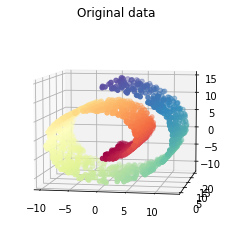

In [3]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Spectral)

ax.set_title("Original data")

In [4]:
raw_dm = cdist(X, X)

In [9]:
methods = [
    {
        'name': 'PCA',
        'constructor': partial(PCA, random_state=825, n_components=2),
    },
    {
        'name': 'UMAP',
        'constructor': partial(UMAP, n_neighbors=1499, min_dist=1, random_state=825, n_components=2),
    },
    {
        'name': 'TSNE',
        'constructor': partial(TSNE, random_state=826, n_components=2),
    },
    {
        'name': 'TSNE-Spectral',
        'constructor': partial(TSNE, random_state=826, n_components=2, init='pca'),
    },
    {
        'name': 'LLE',
        'constructor': partial(LocallyLinearEmbedding, random_state=827, n_components=2, n_neighbors=12),
    },
]

In [10]:
def rescale(x):
    shifted = x - x.min()
    return (shifted) / shifted.max() 

In [11]:
y_order = y.argsort()

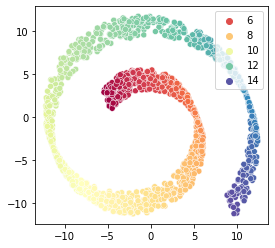

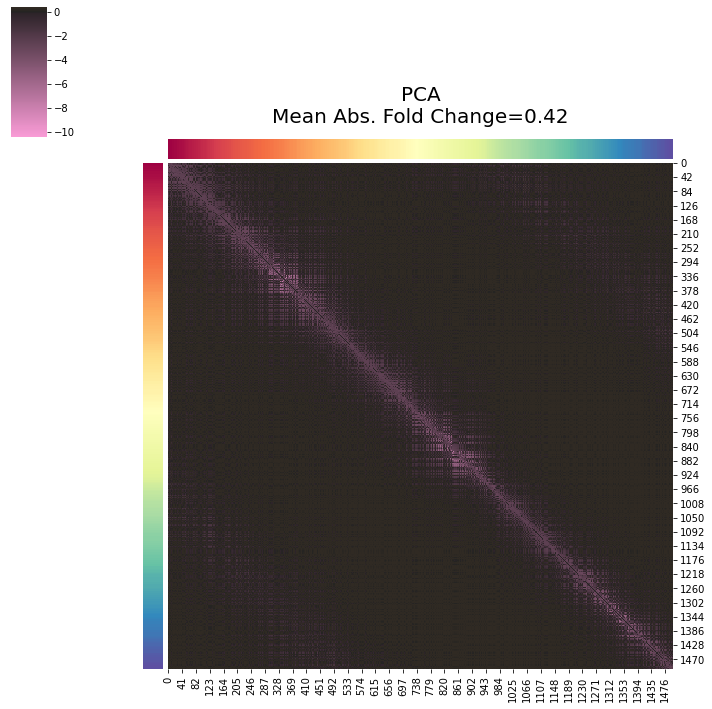

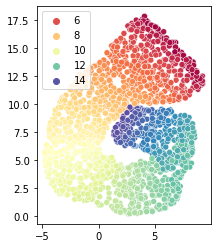

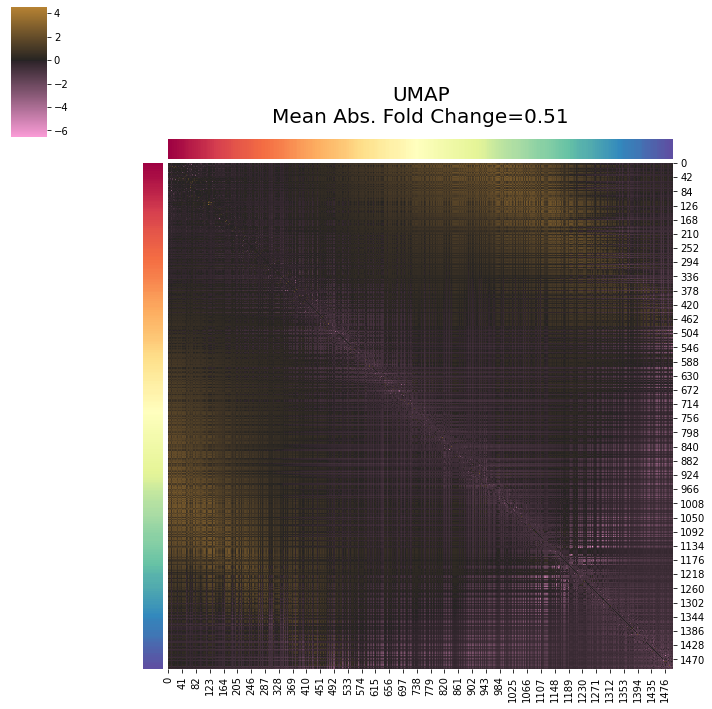

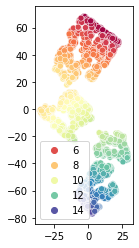

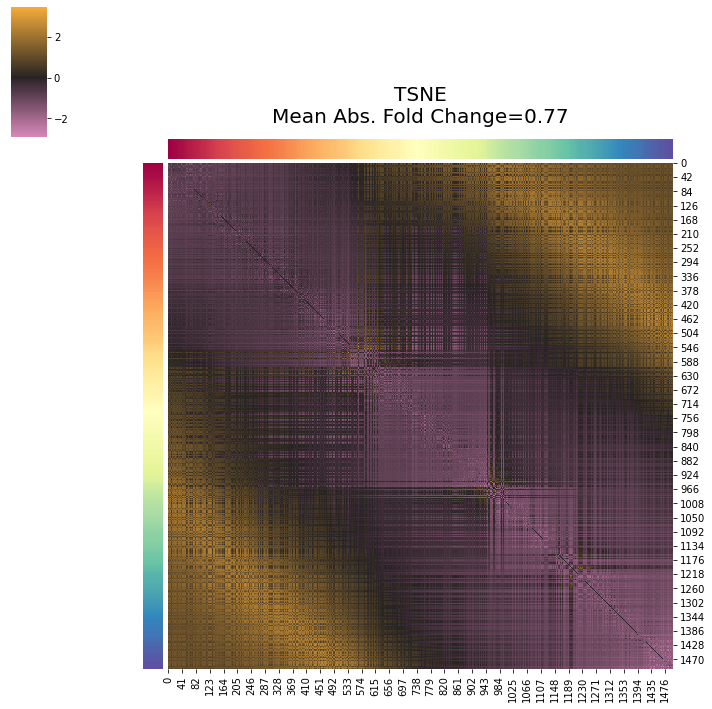

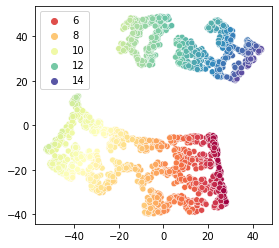

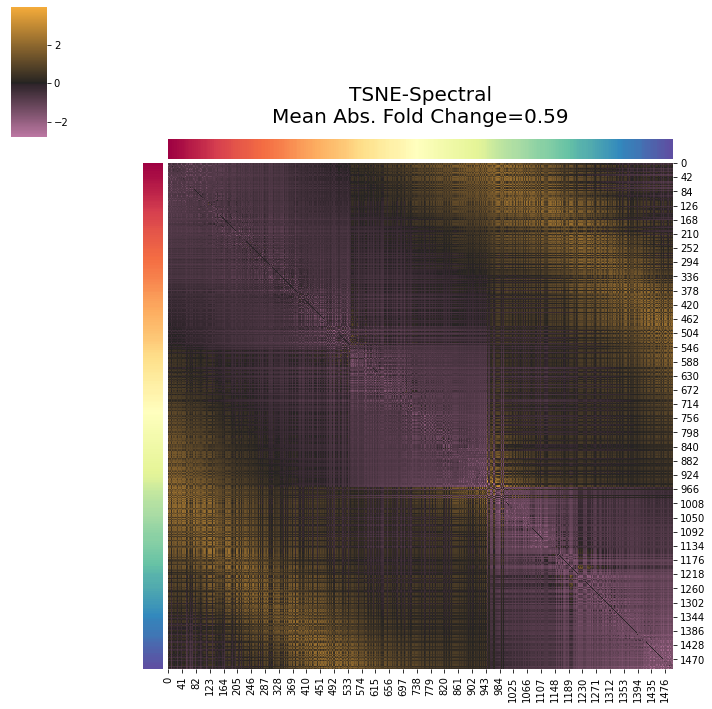

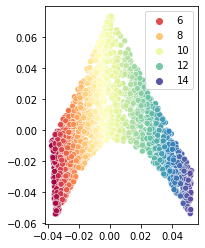

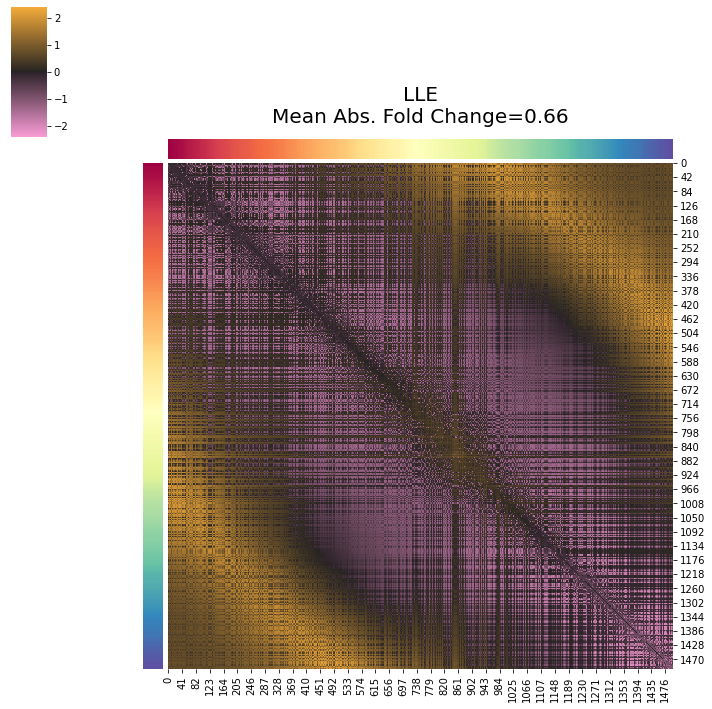

In [12]:

x = np.vstack([X[:, 0], X[:, 1], X[:, 2]]).T
raw_dm = cdist(x, x)
for method in methods:
    name = method['name']
    constructor = method['constructor']
    embedding = constructor().fit_transform(x)

    embedding_dm = cdist(embedding, embedding)

    g = sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=y,
        palette='Spectral'
    )
    g.set_aspect('equal')
    plt.show()

    distance_ratios = pairwise_ratios(raw_dm, embedding_dm[:, :])
    np.fill_diagonal(distance_ratios, 1)
    logratios = np.log2(distance_ratios)
    geom_mean = logratios[np.triu_indices_from(logratios, k=1)].mean()
    logratios = logratios - geom_mean
    np.fill_diagonal(logratios, 0)

    res = X

    cmap = sns.diverging_palette(
        330,
        49,
        s=90,
        l=75,
        center='dark',
        as_cmap=True,
    )

    Z = logratios[y_order].copy()
    Z[:] = Z[:, y_order]

    g = sns.clustermap(
        Z,
        col_colors=plt.cm.Spectral(rescale(y[y_order])),
        row_colors=plt.cm.Spectral(rescale(y[y_order])),
        cmap=cmap,
        # vmin=-1,
        # vmax=1,
        vmax=logratios.max(),
        vmin=logratios.min(),
        center=0,
        col_cluster=False,
        row_cluster=False,
    #     row_linkage=False,
    #     col_linkage=False,
    )
    g.ax_col_dendrogram.set_visible(False)
    triu_ratios = logratios[np.triu_indices_from(logratios, k=1)]
    std = triu_ratios.std()
    mse = np.abs(triu_ratios).mean()
    g.ax_heatmap.set_title(name + 
                           # f'\nSTD={std:.2f}' +
                           f'\nMean Abs. Fold Change={mse:.2f}',
                           fontsize=20, pad=40)
    plt.show()